In [14]:
%load_ext autoreload
%autoreload 2

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from darts import TimeSeries
from darts.utils.data import tabularization as tab
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from darts.metrics import mape, r2_score, rmse
from darts.models import RegressionModel

import utils

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(
    covars_diff, should_diff=True, diff_order=1, should_scale=True, should_log=True
)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(
    covars_nodiff, should_diff=False, should_scale=True, should_log=True
)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(
    covars_diff_yoy, should_diff=True, diff_order=12, should_scale=True, should_log=True
)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1, should_scale=True, should_log=True)


# Ensure that all timeseries are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack the covariates
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(
    covars_diff_yoy_scaled
)


# Split the data into training and validation sets
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(
    pd.Timestamp("2016-01-01")
)

# Reconvert to DataFrame since statsmodels does not support TimeSeries objects
train = train_ts_scaled.pd_dataframe()
validation = val_ts_scaled.pd_dataframe()
history = pd.concat([train, validation])

In [16]:
timeseries_crossval = TimeSeriesSplit(n_splits=10)

In [17]:
lags_past_covariates = {
        "US_UNEMPLOYMENT_RATE": [-3],
        "US_CPI": [-3],
        "US_TB_YIELD_3YRS": [-2],
        "YIELD_CURVE": [-1],
        "EXPINF10YR": [-1],
        "MICH": [-1],
        "US_TB_YIELD_5YRS": [-1],
        "NEWS_SENTIMENT": [-2],
    }

unwanted_columns = [c for c in train_covariates_scaled.columns if c not in lags_past_covariates.keys()]
train_covariates_scaled = train_covariates_scaled.drop_columns(unwanted_columns)
covariates_scaled = covariates_scaled.drop_columns(unwanted_columns)


model = linear_model.LassoCV(cv=timeseries_crossval)
ts_model = RegressionModel(
    model=model,
    lags=[-5, -10],
    lags_past_covariates=3,
    output_chunk_length=12,
)

ts_model.fit(
    series=train_ts_scaled,
    past_covariates=train_covariates_scaled,
)

RegressionModel(lags=[-5, -10], lags_past_covariates=3, lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, model=LassoCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)), multi_models=True, use_static_covariates=True)

In [18]:
forecasts = utils.make_forecasts(ts_model, ts, ts_scaled, covariates_scaled, pipeline)

In [19]:
utils.evaluate_by_horizon(forecasts)

component,mean_abs_pct_error,mean_squared_error,mean_abs_error,root_mean_squared_error
horizon,,,,
1,7.699567,0.037644,0.145623,0.194021
2,13.605493,0.111194,0.253930,0.333458
3,18.536777,0.194097,0.335033,0.440564
4,22.968656,0.279834,0.410559,0.528994
5,27.229762,0.373572,0.490582,0.611205
6,31.424851,0.492969,0.571297,0.702117
7,35.279441,0.623838,0.645416,0.789834
8,39.358616,0.760959,0.728403,0.872330
9,43.078626,0.910220,0.807156,0.954055


In [7]:
fore_ts = utils.get_ts_by_forecast_horizon(forecasts)

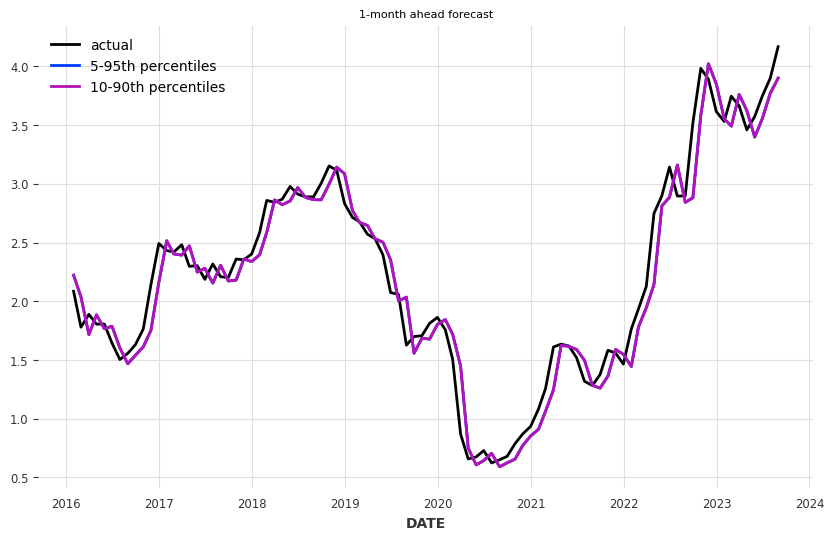

In [8]:
utils.plot_forecast_for_horizon(
    1, fore_ts, axs=plt.subplots(1, 1, figsize=(10, 6))[1], ts=ts
)

In [9]:
from darts.models import XGBModel


model = XGBModel(
    # max_depth=5,
    # n_estimators=100,
    # n_jobs=10,
    lags=[-5, -10, -12],
    lags_past_covariates=lags_past_covariates,
    output_chunk_length=12,
    verbose=True,
)

model.fit(train_ts_scaled, train_covariates_scaled)

XGBModel(lags=[-5, -10, -12], lags_past_covariates={'US_UNEMPLOYMENT_RATE': [-3], 'US_CPI': [-3], 'US_TB_YIELD_3YRS': [-2], 'YIELD_CURVE': [-1], 'EXPINF10YR': [-1], 'MICH': [-1], 'US_TB_YIELD_5YRS': [-1], 'NEWS_SENTIMENT': [-2]}, lags_future_covariates=None, output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, verbose=True)

In [10]:
forecasts = utils.make_forecasts(model, ts, ts_scaled, covariates_scaled, pipeline)

In [11]:
utils.evaluate_by_horizon(forecasts)

component,mean_abs_pct_error,mean_squared_error,root_mean_squared_error
horizon,,,
1,8.011241,0.043379,0.208276
2,14.881596,0.126522,0.355700
3,19.255717,0.175493,0.418919
4,26.781413,0.303773,0.551156
5,33.430046,0.472353,0.687279
6,37.149532,0.677259,0.822957
7,41.864877,0.853970,0.924105
8,44.938928,1.093695,1.045799
9,48.334937,1.279046,1.130949


In [12]:
ts_forecasts = utils.get_ts_by_forecast_horizon(forecasts)

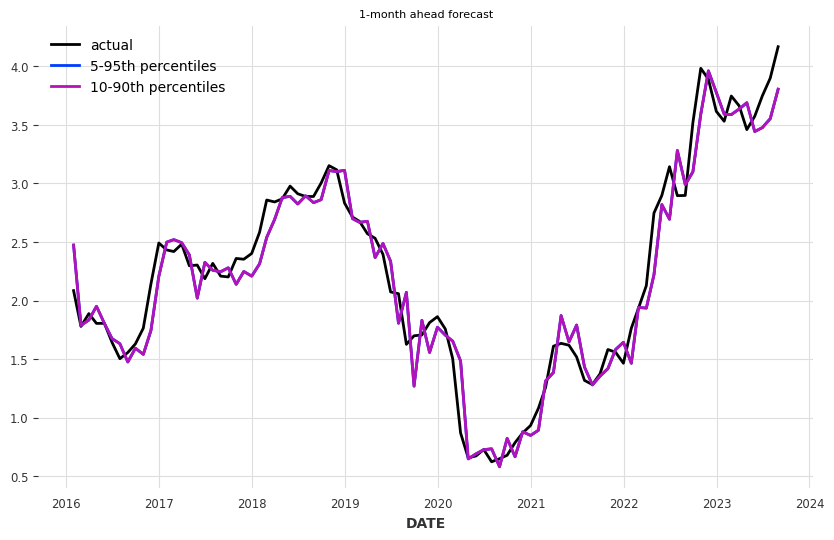

In [13]:
utils.plot_forecast_for_horizon(
    1, ts_forecasts, axs=plt.subplots(1, 1, figsize=(10, 6))[1], ts=ts
)